# 5.5 Model Selection and Hyperparameter Tuning

This section will use the tools developed in the previous section to select between two prediction models, a problem known as **model selection**. Model selection encompasses many different kinds of questions:

- Hyperparameter Tuning: How do we choose hyperparameters, such as $k$ in $k$-nearest neighbors?
- Algorithm Selection: Is linear regression or $k$-nearest neighbors better for modeling our data?
- Feature Selection: Which set of features should we include in our model? (It is not always best to include all the features at our disposal.)

In the previous section, we saw how to use training and validation sets to estimate how well the model will perform on future data. Since one goal of machine learning is to build a model that will produce accurate predictions, a natural way to select a model is to choose the one that minimizes the validation error.

In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
pd.options.display.max_rows = 5

housing_df = pd.read_csv("https://raw.githubusercontent.com/dlsun/data-science-book/master/data/AmesHousing.txt",
                      sep="\t")
housing_df

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2928,2929,924100070,20,RL,77.0,10010,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2006,WD,Normal,170000
2929,2930,924151050,60,RL,74.0,9627,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,11,2006,WD,Normal,188000


# Hyperparameter Tuning

How do we choose $k$ in $k$-nearest neighbors? We can simply try all values of $k$ and pick the one with the smallest (test) MSE.

4     1.359144e+09
3     1.377104e+09
          ...     
29    1.888707e+09
30    1.904657e+09
Length: 30, dtype: float64

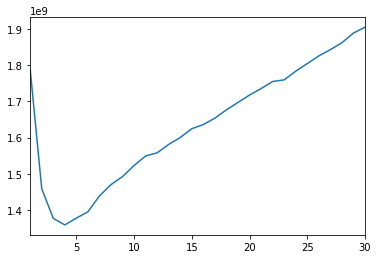

In [14]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline

features = ["Lot Area", "Gr Liv Area",
            "Full Bath", "Half Bath", "Bedroom AbvGr",
            "Year Built", "Yr Sold",
            "Neighborhood", "Bldg Type"]
X, y = housing_df[features], housing_df["SalePrice"]

def get_cv_error(k):
    # define pipeline
    encoder = make_column_transformer(
        (OneHotEncoder(sparse=False, handle_unknown="ignore"), 
         ["Neighborhood", "Bldg Type"]),
        remainder="passthrough"
    )
    scaler = StandardScaler()
    model = KNeighborsRegressor(n_neighbors=k)
    pipeline = make_pipeline(encoder, scaler, model)
    
    # calculate MSE
    mse = np.mean(-cross_val_score(
        pipeline, housing_df[features], housing_df["SalePrice"], 
        cv=10, scoring="neg_mean_squared_error"
    ))
    return mse
    
ks = pd.Series(
    data=range(1, 31),
    index=range(1, 31)
)
val_errs = ks.apply(get_cv_error)

val_errs.plot.line()
val_errs.sort_values()

The MSE is minimized near $k = 4$, which suggests that a $4$-nearest neighbors model is optimal for prediction.

# Algorithm Selection

Is a $4$-nearest neighbors model better than linear regression? We already have an estimate of the the test error of the $4$-nearest neighbors model from above (it is in `val_errs`). We just need to calculate an estimate of the test error of the linear regression model. Let's set up the pipeline for linear regression:

In [27]:
from sklearn.linear_model import LinearRegression

encoder = make_column_transformer(
    (OneHotEncoder(handle_unknown="ignore"), 
     ["Neighborhood", "Bldg Type"]),
    remainder="passthrough"
)
model = LinearRegression()
pipeline = make_pipeline(encoder, model)

print("Linear regression   MSE: %.2f"% 
      -cross_val_score(pipeline, X, y, cv=10, scoring="neg_mean_squared_error").mean())
print("4-nearest neighbors MSE: %.2f" % val_errs[4])

Linear regression   MSE: 1487512984.22
4-nearest neighbors MSE: 1359144470.91


$4$-nearest neighbors has a lower validation error, so there is no reason to consider the linear regression model any further.

# Model Selection

Suppose we are not sure whether `Yr Sold` should be included in the $4$-nearest neighbors model or not. To determine whether or not it should be included, we can fit a model with `Yr Sold` included and another model with it excluded, and see which model has the better (validation) MSE.

In [10]:
encoder = make_column_transformer(
    (OneHotEncoder(sparse=False, handle_unknown="ignore"), 
     ["Neighborhood", "Bldg Type"]),
    remainder="passthrough"
)
scaler = StandardScaler()
model = KNeighborsRegressor(n_neighbors=4)
pipeline = make_pipeline(encoder, scaler, model)

In [13]:
features = ["Lot Area", "Gr Liv Area",
            "Full Bath", "Half Bath",
            "Bedroom AbvGr", 
            "Year Built", "Yr Sold",
            "Neighborhood", "Bldg Type"]
X, y = housing[features], housing["SalePrice"]

-cross_val_score(pipeline, X, y, cv=10, scoring="neg_mean_squared_error").mean()

1359144470.9055035

In [16]:
features = ["Lot Area", "Gr Liv Area",
            "Full Bath", "Half Bath",
            "Bedroom AbvGr", 
            "Year Built",
            "Neighborhood", "Bldg Type"]
X, y = housing[features], housing["SalePrice"]

-cross_val_score(pipeline, X, y, cv=10, scoring="neg_mean_squared_error").mean()

1272584831.5255544

The MSE actually goes down when we remove `Yr Sold`, so the model is actually better off without this variable.

# Fitting the Final Model

Now that we have determined the optimal model using cross validation, we need to actually fit  the model to be able to make predictions on future data. The key is to fit the model to _all_ of the current data---not just a fraction of the current data, as when we did cross validation. Since we already have an objective estimate of the test error of this model, we do not need to hold out any data for evaluation. We should use all of the data and build the best model that we can.

First, let's set up a pipeline that fits a $4$-nearest neighbor model to the set of features determined above (i.e., with `Yr Sold` removed).

In [28]:
features = ["Lot Area", "Gr Liv Area",
            "Full Bath", "Half Bath",
            "Bedroom AbvGr", 
            "Year Built",
            "Neighborhood", "Bldg Type"]

encoder = make_column_transformer(
    (OneHotEncoder(sparse=False, handle_unknown="ignore"), 
     ["Neighborhood", "Bldg Type"]),
    remainder="passthrough"
)
scaler = StandardScaler()
model = KNeighborsRegressor(n_neighbors=4)
pipeline = make_pipeline(encoder, scaler, model)

Now we are ready to fit the pipeline to the data using `pipeline.fit()`. Notice that we train the model on all of the current data.

In [29]:
X, y = housing[features], housing["SalePrice"]
pipeline.fit(X, y)

Pipeline(memory=None,
     steps=[('columntransformer', ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('onehotencoder', OneHotEncoder(categorical_features=None, categories=None,
       dtype=<class 'numpy.float64'>, handle_unknown='ignor...wski',
          metric_params=None, n_jobs=None, n_neighbors=4, p=2,
          weights='uniform'))])

To make predictions on future data, we can call `pipeline.predict()`. Keep in mind that the features must be formatted in exactly the same way as in the training data.

In [30]:
pipeline.predict(X)

array([167600. , 123875. , 166000. , ..., 121875. , 153312.5, 244725. ])